In [ ]:
# seconf zero in ConvnetBuilder(..0,0,0..)

#timing some bigger number for middle number 

# why len of read csv is lower than rows in csv 

#models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)
#what do those 3 zeros means?

# using (128,128) data of SVHN before glucometer 

# adding data_augmentation , zooming ,rotate ,brightness ,flip 

# use other 1_digit numbers

#more epochs

#freeze , unfreeze tecnique

In [2]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [3]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [4]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

In [5]:
f_model = resnet34
sz=128
bs=32

In [117]:
PATH = 'D:/FAST.Ai/Idea/SVHN/test/'

In [118]:
CSV1 = Path('D:/FAST.Ai/Idea/fastai_ds/SVHN/first_digit.csv')

In [119]:
CSV2 = Path('D:/FAST.Ai/Idea/fastai_ds/SVHN/second_digit.csv')

In [120]:
CSV3 = Path('D:/FAST.Ai/Idea/fastai_ds/SVHN/third_digit.csv')

In [121]:
tfms = tfms_from_model(f_model, sz,crop_type=CropType.NO)
md1 = ImageClassifierData.from_csv(PATH,"test" , CSV1, tfms=tfms, bs=bs)

In [122]:
md2 = ImageClassifierData.from_csv(PATH,"test" , CSV2, tfms=tfms, bs=bs)

In [123]:
md3 = ImageClassifierData.from_csv(PATH,"test" , CSV3, tfms=tfms, bs=bs)

In [124]:
len(md2.trn_ds)

4732

In [125]:
len(md1.trn_ds)

4732

## verification 

In [13]:
x1,y1=next(iter(md1.val_dl))

In [14]:
x2,y2=next(iter(md2.val_dl))

In [15]:
x3,y3=next(iter(md3.val_dl))

In [16]:
i =28

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


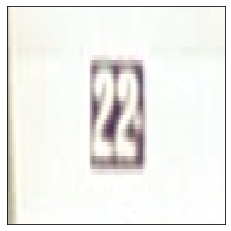

In [17]:
show_img(md1.val_ds.denorm(to_np(x2))[i]);

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


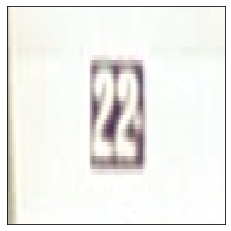

In [18]:
show_img(md2.val_ds.denorm(to_np(x1))[i]);

In [19]:
y3[i],y2[i],y1[i] 

(10, 2, 2)

In [20]:
md1.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

In [21]:
md2.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '99']

In [22]:
md3.classes

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '99']

# Single object detection

In [24]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2,y3): self.ds,self.y2,self.y3 = ds,y2,y3
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i],self.y3[i]))

In [26]:
trn_ds2 = ConcatLblDataset(md1.trn_ds, md2.trn_y,md3.trn_y)
val_ds2 = ConcatLblDataset(md1.val_ds, md2.val_y, md3.val_y)

In [27]:
val_ds2[0][1]

(0, 4, 10)

In [28]:
md1.trn_dl.dataset = trn_ds2
md1.val_dl.dataset = val_ds2

# verification 

In [29]:
x,y=next(iter(md1.val_dl))
idx=3
ima=md1.val_ds.ds.denorm(to_np(x))[idx]

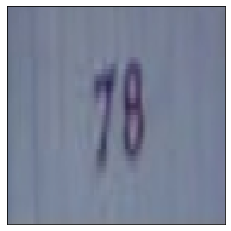

In [30]:
ax = show_img(ima)

In [31]:
y[0][idx]

8

In [32]:
y[1][idx]

7

In [33]:
y[2][idx]

10

# creating the model 

In [102]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(8192,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,len(md1.classes)+len(md2.classes)+len(md3.classes)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md1, models)
learn.opt_fn = optim.Adam

In [107]:
def detn_loss(input, target):
    yekan_t,dahgan_t,sadgan_t = target
    yekan_i,dahgan_i,sadgan_i = input[:, :len(md1.classes)], input[:, len(md1.classes):len(md1.classes)+len(md2.classes)],input[:,len(md1.classes)+len(md2.classes):len(md1.classes)+len(md2.classes)+len(md3.classes)]
    return (F.cross_entropy(yekan_i, yekan_t)+F.cross_entropy(dahgan_i, dahgan_t)+F.cross_entropy(sadgan_i, sadgan_t) )

def detn_acc(input, target):
    yekan_t,dahgan_t,sadgan_t = target
    yekan_i,dahgan_i,sadgan_i = input[:, :len(md1.classes)], input[:, len(md1.classes):len(md1.classes)+len(md2.classes)],input[:,len(md1.classes)+len(md2.classes):len(md1.classes)+len(md2.classes)+len(md3.classes)]
    yekan_i_idx, dahgan_i_idx, sadgan_i_idx = yekan_i.max(1)[1],dahgan_i.max(1)[1] , sadgan_i.max(1)[1]
    t_acc = ((yekan_i_idx == yekan_t)&(dahgan_i_idx==dahgan_t)&(sadgan_i_idx==sadgan_t))
    return (np.array(t_acc).mean())

learn.crit = detn_loss
learn.metrics = [detn_acc]

 82%|████████████████████████████████████████████████████████▉            | 122/148 [05:07<01:06,  2.54s/it, loss=19.5]

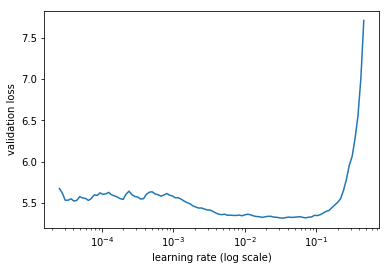

In [108]:
learn.lr_find()
learn.sched.plot()

In [109]:
lr=1e-3

In [110]:
learn.fit(lr, 1, cycle_len=1)

epoch      trn_loss   val_loss   detn_acc                                                                              
    0      5.090976   4.935598   0.054945  


[array([4.9356]), 0.054945054945054944]

In [111]:
learn.save('SVHN_test_128_1_epoch')

In [112]:
learn.load('SVHN_test_128_1_epoch')